# Starting Kit - Relevance 

# Introduction to Challenge
The RelevAI project, which is in the field of Information Retrieval (IR), focuses on academic literature. It is driven by the need to classify the relevance of papers in the scientific literature, a task that grows harder with large text volumes and diverse topics. The project aims to automate the process of assessing document relevance to specific prompts or queries, which has the potential to save users valuable time and effort.

Traditional methods like text matching and keyword search often miss contextual meaning and word relationships, resulting in inaccurate relevance assessments. Therefore, this challenge proposes users to come up with Artificial Intelligence techniques to improve this task, capturing semantic and contextual aspects of the text to better predict its relevance. The successful development of an effective relevance ranking algorithm can have a significant impact on society. It can enhance literature reviews, accelerate scientific research, expedite breakthroughs in diverse fields, facilitate efficient literature searches, simplify information access, and enhance learning and decision-making processes.

# Introduction to Data
This challenge aims to categorize candidate papers based on their alignment with a given prompt. It is formulated as a supervised learning problem, where the input consists of a prompt along with 4 candidate survey papers, and the desired output are the relevance classes to be assigned to each of these papers. Specifically, label 3 denotes the most relevance, 2 for the second most relevance, 1 for the second least relevance, and 0 for the least relevance. Each paper contains a Title, Abstract, and Related Works sections generated by ChatGPT from citations. The prompts were generated by reverse-engineering using ChatGPT and the most relevant paper as a reference.

### Input
Pairs made out of a prompt + paper (title, abstract and related works). Note: each prompt has 4 different papers with different levels of relevance (most relevant, second most relevant, second least relevant and least relevant). Therefore, each prompt appears in four different instances of the dataset, but with different papers in each row (and therefore different labels representing the relevance level).

### Output
Numeric value indicating the level of relevance of a paper with regard to a prompt:
1. Label 3 indicates the highest relevance (most relevant)
2. Label 2 for the second highest (second most relevant)
3. Label 1 for the second lowest (second least relevant)
4. Label 0 for the lowest relevance (least relevant)e.age.

# Evaluation
Initially, the performance of the models will be evaluated using Kendall’s Tau coefficient, which is further explained down below in this notebook. Therefore, you should prioritize approaches that optimize the Kendall’s Tau coefficient. We also present different metrics in the scoring report, such as accuracy and precision, to give a further idea of how well your model is performing. Those other metrics can be used as tie breakers in case of different approaches with the same Kendall’s Tau coefficient.

# This Starting kit notebook

Now that you have an idea about the scope of the challenge, motivations and objectives behind it, data format and evaluation, you may want to get a first taste of the challenge. This starting kit provides a basic baseline using a small sample of the data so that you may better visualize and understand the date, besides being a great example of how you should generate a zip file to submit in the Codabench website. You may play with it in order to get familiar before you start using your creativity to develop your very own solution!

# Credits
This challenge wouldn't be possible without the hard work of different people involved, so we use this section to acknowledge the responsibles for creating this project.

### Database donors
* Benedictus Kent Rachmat
* KHUONG Thanh Gia Hieu

### Project development team members
* Paulo Henrique Couto
* Nageeta Kumari 
* Quang Phuoc HO

# Getting Started Instructions

Before executing the code, we want you to make sure that you have a required setup to run this starting kit.
1. Make sure you are using python 3.9 version  
2. All the following packages must be installed, to check these you can simply use: pip show [name_of_package]  
    - numpy
    - pandas
    - matplotlib
    - tqdm
    - sentence_transformers
    - sklearn
    - torch
    - ipywidgets
    - wordcloud

If any of these are not installed, simply use: pip install [name_of_package]



***
# Setup
***
`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB='google.colab' in str(get_ipython())

In [2]:
if COLAB:
    # clone github repo
    !git clone https://github.com/paulohenriquecrs/M1-AI-Challenge---Relevance-Group.git

    # move to the HEP starting kit folder
    %cd M1-AI-Challenge---Relevance-Group/Starting_Kit/

    !pip install -q --upgrade sentence-transformers transformers

***
# Imports
***

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from tqdm.notebook import tqdm

from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from scipy.stats import kendalltau

import torch

import warnings
warnings.filterwarnings("ignore")
tqdm.pandas()

C:\Users\Paulo Couto\anaconda3\envs\M1_AI-Challenge\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


***
# Directories
***

In [4]:
root_dir = "./"
# Input data directory to read training data from
input_dir = root_dir + "sample_data/"
# Reference data directory to read test labels from
reference_dir = root_dir + "sample_data/"
# Output data directory to write predictions to
output_dir = root_dir + "sample_result_submission"
# Program directory
program_dir = root_dir + "ingestion_program"
# Score directory
score_dir = root_dir + "scoring_program"
# Directory to read submitted submissions from
submission_dir = root_dir + "sample_code_submission"

***
# Add directories to path
***

In [5]:
sys.path.append(input_dir)
sys.path.append(reference_dir)
sys.path.append(output_dir)
sys.path.append(program_dir)
sys.path.append(submission_dir)

***
# Data
***
1. Load Data
2. Preprocess data


### ⚠️ Note:
The data used here is sample data is for demonstration only to get a view of what the data looks like.

In [6]:
class Data():

  def __init__(self):

      self.df = None

      print("==========================================")
      print("Data")
      print("==========================================")

  def load_data(self):
    """
      Loads data from csv file
    """
    print("[*] Loading Data")

    # data file path
    data_file = os.path.join(input_dir, 'relevance_sample_data.csv')
    
    # read data
    self.df = pd.read_csv(data_file)


  def _text_to_dict(self, text):
    """
    Converts a text string into a dictionary.

    :param text: A string representation of a dictionary.
    :return: A dictionary object if conversion is successful, otherwise {}.
    """
    try:
      return ast.literal_eval(text)
    except:
      return {}  # Return an empty dictionary in case of an error
    
  def _dict_to_paragraphs(self, dictionary):
    """
    Converts a dictionary into a string of paragraphs.

    :param dictionary: A dictionary.
    :return: A string composed of paragraphs based on the dictionary's key-value pairs.
    """
    text = ''
    for i, (k, v) in enumerate(dictionary.items()):
        text += k.capitalize() + '\n' + v + '\n'
    return text
  
  def transfrom_data(self):

    print("[*] Transforming Data")
    
    # Convert to dictionary
    self.df['most_relevant_dict'] = self.df['most_relevant'].apply(self._text_to_dict)
    self.df['second_most_relevant_dict'] = self.df['second_most_relevant'].apply(self._text_to_dict)
    self.df['second_least_relevant_dict'] = self.df['second_least_relevant'].apply(self._text_to_dict)
    self.df['least_relevant_dict'] = self.df['least_relevant'].apply(self._text_to_dict)


    # Convert from dictionary to text
    self.df['most_relevant_text'] = self.df['most_relevant_dict'].apply(self._dict_to_paragraphs)
    self.df['second_most_relevant_text'] = self.df['second_most_relevant_dict'].apply(self._dict_to_paragraphs)
    self.df['second_least_relevant_text'] = self.df['second_least_relevant_dict'].apply(self._dict_to_paragraphs)
    self.df['least_relevant_text'] = self.df['least_relevant_dict'].apply(self._dict_to_paragraphs)
  
  def prepare_data(self):

    print("[*] Prepare Data for Training")
    

    # Label the Data
    self.df['most_relevant_label'] = 3
    self.df['second_most_relevant_label'] = 2
    self.df['second_least_relevant_label'] = 1
    self.df['least_relevant_label'] = 0

    X = pd.DataFrame()
    X["prompt"] = self.df['prompt'].tolist() + self.df['prompt'].tolist() + self.df['prompt'].tolist() + self.df['prompt'].tolist()
    X["text"] = self.df['most_relevant_text'].tolist() + self.df['second_most_relevant_text'].tolist() + self.df['second_least_relevant_text'].tolist() + self.df['least_relevant_text'].tolist()
    y = self.df['most_relevant_label'].tolist() + self.df['second_most_relevant_label'].tolist() + self.df['second_least_relevant_label'].tolist() + self.df['least_relevant_label'].tolist()

    # Shuffle X and y
    X, y = shuffle(X, y, random_state=42)

    # train test split
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)


  def get_train_data(self):
    return self.X_train, self.y_train
  
  def get_test_data(self):
    return self.X_test, self.y_test
  
  def show_random_sample(self):
    random_sample_index = np.random.randint(0, len(self.df))

    print("Prompt:\n", self.df.iloc[random_sample_index]['prompt'], "...\n")
    print("Most Relevant Text:\n", self.df.iloc[random_sample_index]['most_relevant_text'][:300], "...\n")
    print("Second Most Relevant Text:\n", self.df.iloc[random_sample_index]['second_most_relevant_text'][:300], "...\n")
    print("Second Least Relevant Text:\n", self.df.iloc[random_sample_index]['second_least_relevant_text'][:300], "...\n")
    print("Least Relevant Text:\n", self.df.iloc[random_sample_index]['least_relevant_text'][:300], "...\n")


  def show_data_stats(self):
    print("X_train shape: ", np.shape(self.X_train))
    print("y_train shape: ", np.shape(self.y_train))
    print("X_test shape: ", np.shape(self.X_test))
    print("y_test shape: ", np.shape(self.y_test))
    
  def get_data_viz(self):
    prompt_len = self.df['prompt'].apply(len)
      
    most_relevant_text_len = self.df['most_relevant_text'].apply(len)
    second_most_relevant_text_len = self.df['second_most_relevant_text'].apply(len)
    second_least_relevant_text_len = self.df['second_least_relevant_text'].apply(len)
    least_relevant_text_len = self.df['least_relevant_text'].apply(len)

    texts_len = most_relevant_text_len + second_most_relevant_text_len + second_least_relevant_text_len + least_relevant_text_len
    return prompt_len, texts_len

In [7]:
# Initilaize data
data = Data()

Data


In [8]:
# load data
data.load_data()

[*] Loading Data


In [9]:
# transform data
data.transfrom_data()

[*] Transforming Data


In [10]:
# prepare data
data.prepare_data()

[*] Prepare Data for Training


In [11]:
# show random sample from data
data.show_random_sample()

Prompt:
 Write a systematic survey or overview about the impact of e-learning on higher education, including its advantages, disadvantages, and student perceptions. Limit yourself to 2 sentences. ...

Most Relevant Text:
 Title
E-Learning as a Means to Improve the Quality of Higher Education
Abstract
The use of e-learning has become an important part of higher education. It expands the pedagogical resources, assists students in their learning, develops learners’ skills, motivation and knowledge, prepares them for bei ...

Second Most Relevant Text:
 Title
Effectiveness of E-Learning System among Postgraduate Students in Kuala Lumpur, Malaysia
Abstract
The purpose of this study is to investigate the effectiveness of e-Learning system based on the usage, perception and satisfaction among Postgraduate students in relation to the differences betwee ...

Second Least Relevant Text:
 Title
The impact of RICS education reform on building surveying
Abstract
Purpose – It is of major concern to 

In [12]:
# get train test data
X_train, y_train = data.get_train_data()
X_test, Y_test = data.get_test_data()

In [13]:
print("Simple data stats: shape of the train and test sets\n")
data.show_data_stats()

Simple data stats: shape of the train and test sets

X_train shape:  (1600, 2)
y_train shape:  (1600,)
X_test shape:  (400, 2)
y_test shape:  (400,)


***
# Visualize

In this section we provide some basic data visualization so that you can have a better understanding of the data in a clear and intuitive way using visual tools. This can be very usefull when you have to choose your preprocessing strategies to deal with the data and the hyperparameters for your models.

First, we plot the length histograms of the prompts and the texts. This provides a general idea of the lenght of the inputs we'll use in our models, which can be very important when we think of the computational cost and the preprocessing strategies (embeddings, tokenizers, etc.).

We also visualize 5 random samples using word cloud.
Word cloud visualization can provide a quick and intuitive way to understand the key themes of the text. Within the prompt, discernible words signal their significance, identifying them as crucial themes or topics. When comparing with the world cloud of most relevant, these key words appear to be similar in terms of interpretation. The similarity of word cloud between paper and prompt decreases based on the level of relevance.

In [14]:
import importlib

def check_and_install_wordcloud():
    try:
        importlib.import_module('wordcloud')
        print("Wordcloud is already installed.")
    except ImportError:
        print("Wordcloud is not installed. Installing...")
        !pip install wordcloud
        print("Wordcloud has been successfully installed.")

# Check and install Wordcloud
check_and_install_wordcloud()

Wordcloud is already installed.


In [15]:
from wordcloud import WordCloud

class Visualize():

    def __init__(self, data):

        print("==========================================")
        print("Visualize")
        print("==========================================")
        self.data = data


    def visualize_data(self):
        prompt_len, texts_len = data.get_data_viz()
        plt.figure(figsize=(10,3))
        
        plt.hist(prompt_len, bins=range(min(prompt_len), max(prompt_len) + 1, 10), edgecolor='black')
        plt.xlabel('String Length')
        plt.ylabel('Frequency')
        plt.title('Histogram of Prompt Lengths - Avg length = ' + str(round(prompt_len.mean())))
        plt.show()

        plt.figure(figsize=(10,3))
        plt.hist(texts_len, bins=range(min(texts_len), max(texts_len) + 1, 500), color='red', edgecolor='black')
        plt.xlabel('String Length')
        plt.ylabel('Frequency')
        plt.title('Histogram of Texts Lengths - Avg length = ' + str(round(texts_len.mean())))
        plt.show()

        random_array = np.random.randint(0, len(self.data.df), size=5)
        data_df = data.df.iloc[random_array]
        columns = ['prompt', 'most_relevant_text', 'second_most_relevant_text', 'second_least_relevant_text', 'least_relevant_text']

        # Iterate through rows in the DataFrame
        for index, row in data_df.iterrows():
            plt.figure(figsize=(12, 8))
            
            # Create a WordCloud for each column
            for i, column in enumerate(columns, 1):
                plt.subplot(2, 3, i)
                wordcloud = WordCloud(width=400, height=400, background_color='white').generate(row[column])
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.title(f'{column}')
                plt.axis('off')

            print((f'Relevance WordClouds for Prompt: {row["prompt"]}'))
            plt.show()


Visualize


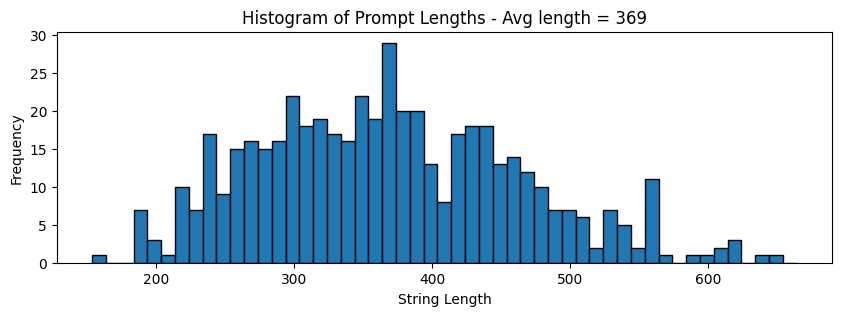

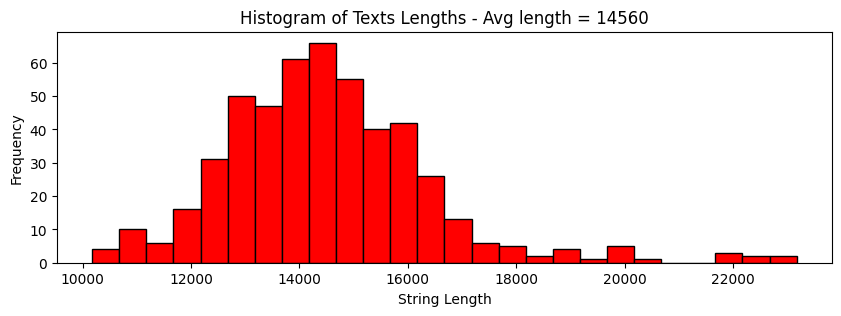

Relevance WordClouds for Prompt: Write a systematic survey or overview about the mining, mineralogy, uses, sustainability, and environmental impact of rare earth elements, including the current availability, pricing, and major operating mines worldwide.


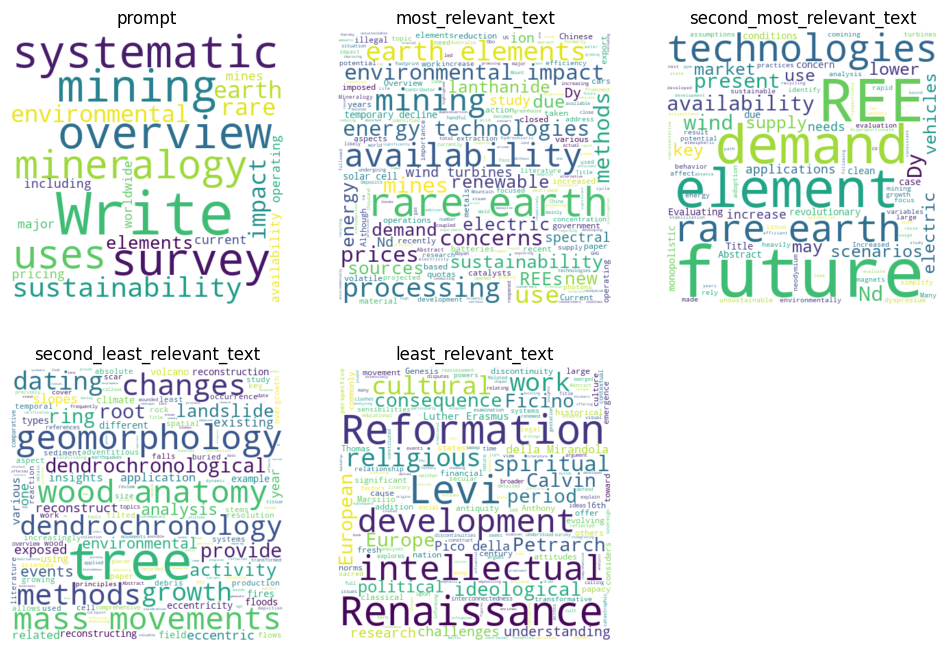

Relevance WordClouds for Prompt: Write a systematic survey or overview about Margaret Cavendish's epistemology, including her treatment of 'exterior knowledge' and 'interior knowledge' in relation to her natural philosophy.


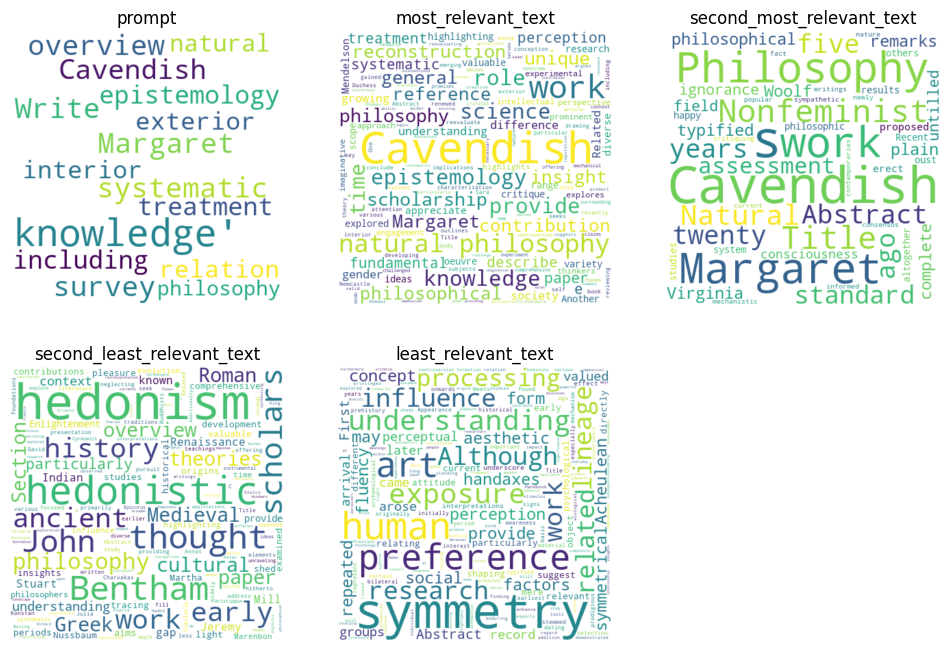

Relevance WordClouds for Prompt: Write a systematic survey or overview about the current state of federated learning techniques used in aerial-ground air quality sensing frameworks with UAV swarms, including the challenges, advancements, and potential applications in environmental monitoring and management.


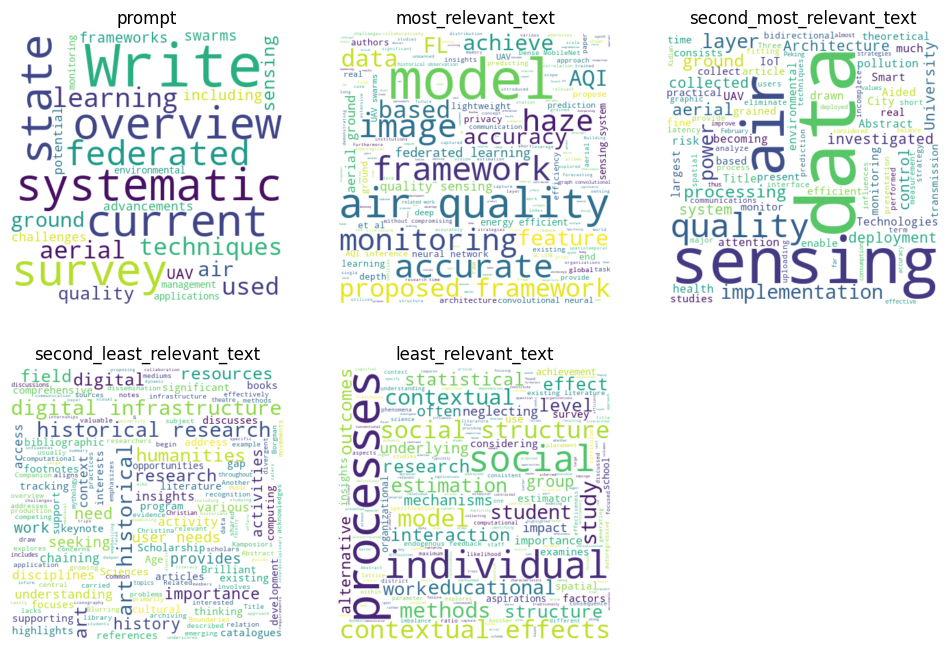

Relevance WordClouds for Prompt: Write a systematic survey or overview about the use of augmented reality in the annotation and preservation of megalithic art, focusing on the development and evaluation of the MAAP Annotate tool. Discuss the potential impact of this technology on the study and accessibility of megalithic art for both archaeologists and the general public.


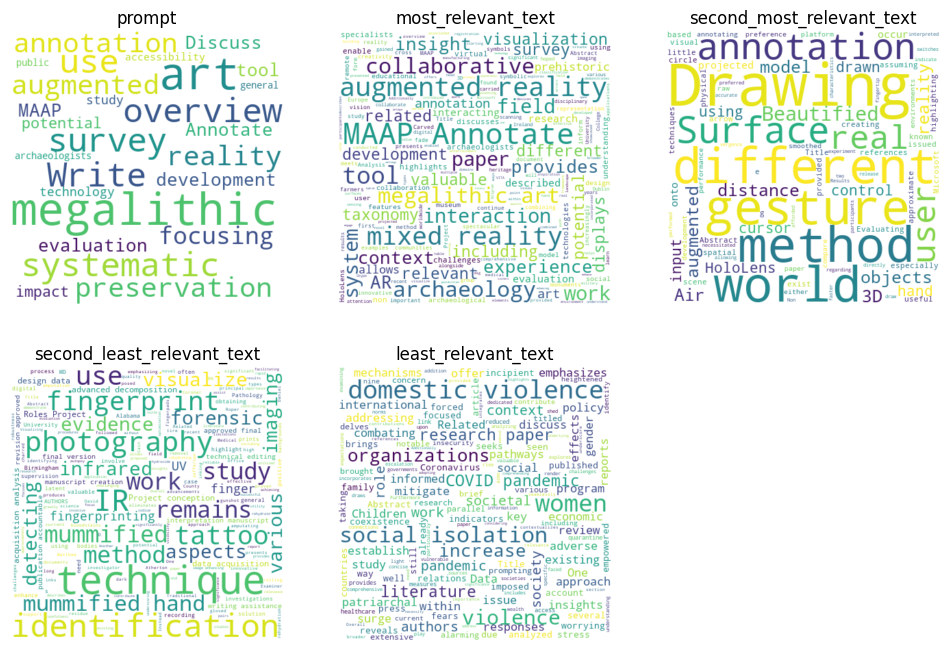

Relevance WordClouds for Prompt: Write a systematic survey or overview about modeling organizational adaptation as a simulated annealing process, including the dual-level model, stochastic learning model, and the relationship between organizational design and performance.


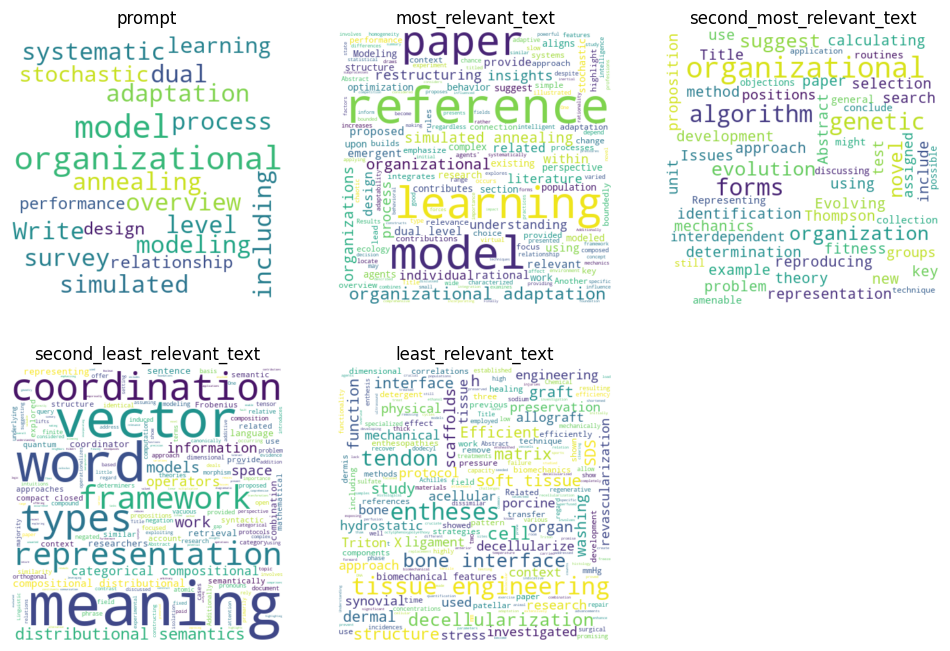

In [16]:
# Initilaize Visualize
visualize = Visualize(data=data)
visualize.visualize_data()

***
# Import Submission Model
***
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: initializes classifier
- `fit`: gets train data and labels as input to train the classifier
- `predict`: gets test data and outputs predictions made by the trained classifier


In this example code, the `Model` class implements a Gradient Boosting Classifier model. You can find the code in `M1-Challenge-Class-2024/Relevance/Starting_Kit/sample_code_submission/model.py`. You can modify it the way you want, keeping the required class structure and functions there. More instructions are given inside the `model.py` file. If running in Collab, click the folder icon in the left sidebar to open the file browser.

In [17]:
from model import Model

***
# Program
***
**`Ingestion program`** is responsible to run the submission of a participant on Codabench platform. **`Program`** is a simplified version of the **Ingestion Program** to show to participants how it runs a submission.
1. Train a model on train data
2. Predict using Test data

In [18]:
class Program():

    def __init__(self, data):

        # used to keep object of Model class to run the submission
        self.model = None
        # object of Data class used here to get the train and test sets
        self.data = data

        # results
        self.results = []

        print("==========================================")
        print("Program")
        print("==========================================")
    
    def initialize_submission(self):
        print("[*] Initializing Submmited Model")
        self.model = Model()
        X_train_raw, self.y_train  = self.data.get_train_data()
        self.X_train = self.model.prepare_data(X_train_raw, "Training")
        X_test_raw, _  = self.data.get_test_data()
        self.X_test = self.model.prepare_data(X_test_raw, "Testing")

    def fit_submission(self):
        print("[*] Calling fit method of submitted model")
        self.model.fit(self.X_train, self.y_train)


    def predict_submission(self):
        print("[*] Calling predict method of submitted model")
        self.y_test_hat = self.model.predict(self.X_test)

       

In [19]:
# Intiialize Program
program = Program(data=data)

Program


In [20]:
# Initialize submitted model
program.initialize_submission()

[*] Initializing Submmited Model
[*] - Initializing Classifier
[*] Prepare Data for Training


  0%|          | 0/1600 [00:00<?, ?it/s]

[*] Prepare Data for Testing


  0%|          | 0/400 [00:00<?, ?it/s]

In [21]:
# Call fit method of submitted model
program.fit_submission()

[*] Calling fit method of submitted model
[*] - Training Classifier on the train set


In [22]:
# Call predict method of submitted model
program.predict_submission()

[*] Calling predict method of submitted model
[*] - Predicting test set using trained Classifier


***
# Score
***

The model’s performance is evaluated using several metrics, including precision, recall, F1-score, and Kendall’s Tau. These metrics provide a comprehensive view of the model’s performance across all classes. Precision measures the model’s exactness, recall measures its completeness, the F1-score balances precision and recall, and Kendall’s Tau measures the correlation between the predicted and actual rankings. 

1.	Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives. It is also known as Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.

2.	Recall (Sensitivity): Recall is the ratio of correctly predicted positive observations to all the actual positives. It is also known as Sensitivity, Hit Rate, or True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.

3.	F1 Score: The F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. It is suitable for uneven class distribution problems.

4.	Support: Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing.

5.	Accuracy: Accuracy is the most intuitive performance measure. It is simply a ratio of correctly predicted observation to the total observations. One may think that if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost the same.

6.	Macro Avg: Macro-average method can be used when you want to know how the model performs overall across the sets of data. You should not come up with any specific decision with this average.

7.	Weighted Avg: In contrary to macro-average method, if you want to know how the model is performing with respect to the most frequent class, you should use a weighted-average method. This will aggregate the contributions of all classes to compute the average metric.

8.	Kendall’s Tau: Kendall’s Tau is a measure of correlation. It gives a value between -1 and 1. A value close to 1 means that there’s a strong positive correlation between the two variables, and a value close to -1 means that there’s a strong negative correlation. A value close to 0 means that there’s no correlation. In your case, the value is approximately 0.70, indicating a good agreement.

9. Cohen's Kappa: Cohen's Kappa (κ) is a statistical measure used to quantify the level of agreement between two raters (or judges, observers, etc.) who each classify items into categories. It's especially useful in situations where decisions are subjective and the categories are nominal.<br>Cohen's Kappa is therefore a measure of how reliably two raters measure the same thing.

Currently, Kendall's Tau score is used to rank participants' submission.

More info in: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html


In [23]:
class Score():

    def __init__(self, data, program):

        self.data = data
        self.program = program

        print("==========================================")
        print("Score")
        print("==========================================")

    def compute_scores(self):
        print("[*] Computing scores")

        _, y_test = self.data.get_test_data()
        y_test_hat = self.program.y_test_hat

        # Classification report
        print(classification_report(y_test, y_test_hat))

        k_tau, _ = kendalltau(y_test, y_test_hat)
        print(f"Kendall's Tau: {k_tau}")

In [24]:
# Initialize Score
score = Score(data=data, program=program)

Score


In [25]:
# Compute Score
score.compute_scores()

[*] Computing scores
              precision    recall  f1-score   support

           0       0.53      0.66      0.59        96
           1       0.55      0.46      0.50       107
           2       0.76      0.75      0.75        91
           3       0.86      0.84      0.85       106

    accuracy                           0.67       400
   macro avg       0.68      0.68      0.67       400
weighted avg       0.68      0.67      0.67       400

Kendall's Tau: 0.7686748624564854


***
# Submissions
***

### **Unit Testing**

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission.
<br>
Keep the sample code simple.<br>

<code>python3</code> is required for this step

### **Test Ingestion Program**

In [26]:
!python $program_dir/ingestion.py

############################################
### Ingestion Program
############################################

[*] Loading Data
[*] Transforming Data
[*] Prepare Data for Training
[*] Initializing Submmited Model
[*] - Initializing Classifier
[*] Prepare Data for Training
  0%|          | 0/1600 [00:00<?, ?it/s]
[*] Prepare Data for Testing
  0%|          | 0/400 [00:00<?, ?it/s]
[*] Calling fit method of submitted model
[*] - Training Classifier on the train set
[*] Calling predict method of submitted model
[*] - Predicting test set using trained Classifier
[*] Saving ingestion result

---------------------------------
[OK] Total duration: 0:02:45.962325
---------------------------------

----------------------------------------------
[OK] Ingestions Program executed successfully!
----------------------------------------------




C:\Users\Paulo Couto\anaconda3\envs\M1_AI-Challenge\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


### **Test Scoring Program**

In [27]:
!python $score_dir/score.py

############################################
### Scoring Program
############################################

[*] Reading predictions
[OK]
[*] Computing scores
              precision    recall  f1-score   support

           0       0.53      0.66      0.59        96
           1       0.55      0.46      0.50       107
           2       0.76      0.75      0.75        91
           3       0.86      0.84      0.85       106

    accuracy                           0.67       400
   macro avg       0.68      0.68      0.67       400
weighted avg       0.68      0.67      0.67       400

Kendall's Tau: 0.7686748624564854
[OK]
[*] Writing scores
[OK]

---------------------------------
[OK] Total duration: 0:00:00.015660
---------------------------------

----------------------------------------------
[OK] Scoring Program executed successfully!
----------------------------------------------




### **Prepare the submission**

Finally, we generate a zip file that can be submitted on the Codabench Challenge page! If all the steps so far worked well, it means your code in model.py should work just fine with the ingestion and scoring programs of the Codabench platform. To submit your work, you just need to go to the Challenge page on Codabench using the link down below and submit the zip file that is generated by the following cell. If it is your first time using Codabench, you will need to create an account before being able to register in this specifc competition. The approval for your request to register may take more than a day, so just patiently wait! Once you have been approved, then you can go to the "My Submissions" page and create a new Submission upload! It may take several hours to run your code due to the dataset size, but you can just come back after a while to see if your result is already available on the "Results" page.

Codabench Challenge page: https://www.codabench.org/competitions/1946/

##### Good luck!

In [28]:
import datetime
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
code_submission = 'Relevance-code_submission_' + the_date + '.zip'
zipdir(code_submission, submission_dir)
print("Submit : " + code_submission + " to the competition")
print("You can find the zip file in `M1-AI-Challenge---Relevance-Group/Starting_Kit/")


Submit : Relevance-code_submission_24-03-18-15-49.zip to the competition
You can find the zip file in `M1-Challenge-Class-2024/Relevance/Starting_Kit/
